In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor, Ridge, ElasticNet
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

import warnings
warnings.filterwarnings('ignore')

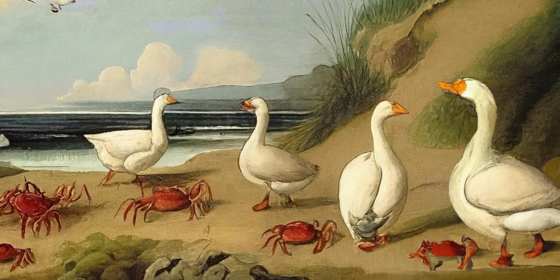

In [28]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
sub = pd.read_csv("sample_submission.csv", index_col=0)

train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,0.5500,0.4125,0.1625,1.715145,0.609514,0.396893,0.566990,4.0
1,F,1.5125,1.2125,0.4000,31.312023,13.395139,6.265239,8.930093,10.0
2,F,1.5125,1.1750,0.4125,31.552993,14.670866,6.279414,9.922325,11.0
3,I,0.8000,0.6000,0.2000,4.620969,3.019222,0.978058,1.417475,7.0
4,I,1.3875,1.0875,0.3625,24.323871,11.651644,5.712424,5.386405,8.0


In [45]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             15000 non-null  object 
 1   Length          15000 non-null  float64
 2   Diameter        15000 non-null  float64
 3   Height          15000 non-null  float64
 4   Weight          15000 non-null  float64
 5   Shucked Weight  15000 non-null  float64
 6   Viscera Weight  15000 non-null  float64
 7   Shell Weight    15000 non-null  float64
 8   Age             15000 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.7 MB


In [29]:
train["Sex"].unique()

array(['I', 'F', 'M', 'Diameter'], dtype=object)

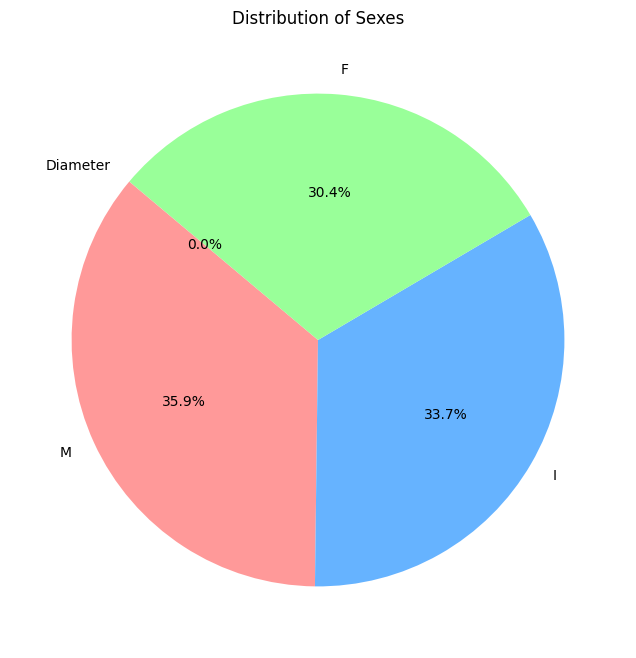

In [31]:
s_c = train['Sex'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(s_c, labels=s_c.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribution of Sexes')
plt.show()

In [19]:
train["Sex"] = train["Sex"].replace("Diameter", "I")

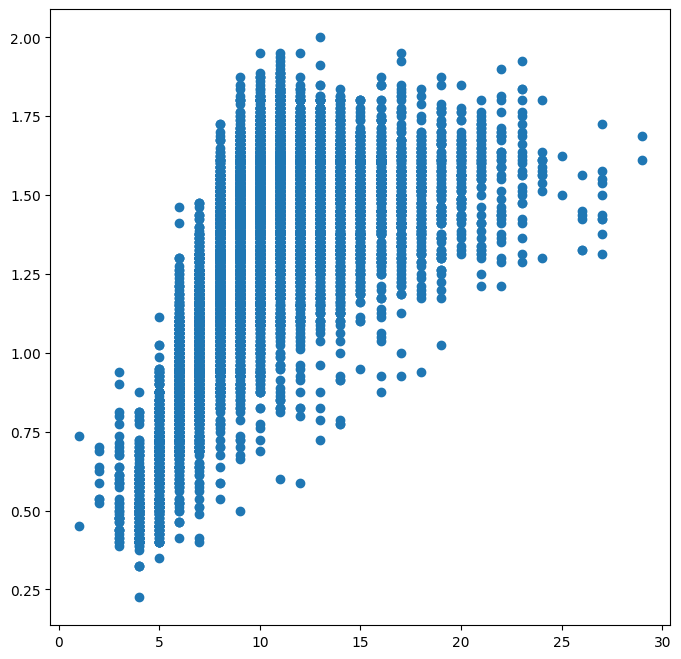

In [43]:
plt.figure(figsize=(8, 8))
plt.scatter(x=train["Age"], y=train["Length"])
plt.show()

# Feature engineering

In [21]:

# Viscera Ratio = Viscera Weight / Weight
# Shell Ratio = Shell Weight / Weight
# Shell-to-Body Ratio = Shell Weight / (Weight + Shell Weight)
# Meat Yield = Shucked Weight / (Weight + Shell Weight)
# Length-to-Diameter Ratio = Length / Diameter
# Weight-to-VisceraWeight Ratio = Weight / Viscera Weight
# Weight-to-ShellWeight Ratio = Weight / Shell Weight
# Weight-to-ShuckedWeight Ratio = Weight / Shucked Weight

def feature_engineering(df):
    df["Viscera Ratio"] = (df["Viscera Weight"] / df["Weight"])
    df["Shell-to-body Ratio"] = (df["Shell Weight"] / df["Weight"])
    df["Meat Yield"] = df["Shucked Weight"] / (df["Weight"] + df["Shell Weight"])
    df["Length-to-Diameter Ratio"] = (df["Length"] / df["Diameter"])
    df["Weight-to-VisceraWeight Ratio"] = (df["Weight"] / df["Viscera Weight"])
    df["Weight-to-ShellWeight Ratio"] = (df["Weight"] / df["Shell Weight"])
    df["Weight-to-ShuckedWeight Ratio"] = (df["Weight"] / df["Shucked Weight"])
    # df["Diameter^2"] = df["Diameter"] ** 3

    # Lengthni 4taga bo'lib olamiz
    df['Length_Bins'] = pd.qcut(df['Length'], q=4, labels=[1, 2, 3, 4])
    
    # BCI bu hayvonlarni sog'lomligini tekshirish uchun
    df['BCI'] = np.sqrt(df['Length'] * df['Weight'] * df['Shucked Weight'])
    df['Weight_wo_Viscera'] = (df['Shucked Weight'] - df['Viscera Weight'])
    df['Log Weight'] = np.log(df['Weight'] + 1)

    return df

 

## Encoding

In [20]:


def encoder(df):
    enc = OneHotEncoder(sparse_output=False)
    
    enc_data = enc.fit_transform(df[["Sex"]])
    
    enc_df = pd.DataFrame(enc_data, columns=enc.get_feature_names_out(['Sex']), index=df.index)
    
    df = pd.concat([df, enc_df], axis=1)
    
    df.drop("Sex", axis=1, inplace=True)
    
    return df


In [22]:
train = encoder(train)
train = feature_engineering(train)


test = encoder(test)
test = feature_engineering(test)

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Length                         15000 non-null  float64 
 1   Diameter                       15000 non-null  float64 
 2   Height                         15000 non-null  float64 
 3   Weight                         15000 non-null  float64 
 4   Shucked Weight                 15000 non-null  float64 
 5   Viscera Weight                 15000 non-null  float64 
 6   Shell Weight                   15000 non-null  float64 
 7   Age                            15000 non-null  float64 
 8   Sex_F                          15000 non-null  float64 
 9   Sex_I                          15000 non-null  float64 
 10  Sex_M                          15000 non-null  float64 
 11  Viscera Ratio                  15000 non-null  float64 
 12  Shell-to-body Ratio            15000 

## Correlatsiya



<Axes: >

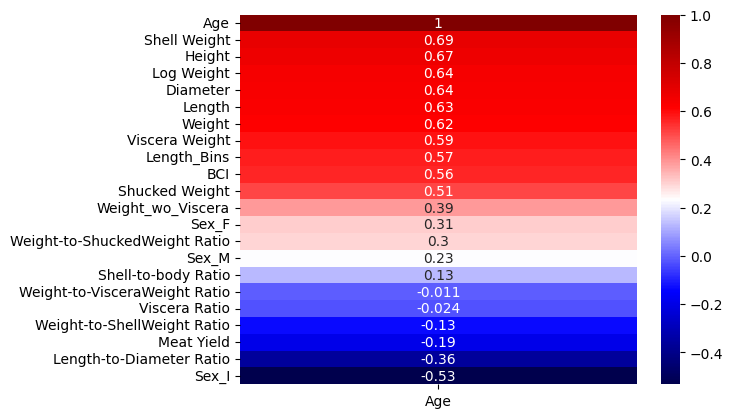

In [27]:
sns.heatmap(train.corr()[["Age"]].sort_values(by="Age", ascending=False), annot=True,  cmap='seismic')

In [ ]:
X = train.drop("Age", axis=1)
y = train["Age"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling

In [ ]:
linear = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression()),
])


lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('lasso', Lasso(alpha=0.0008))
])

huber = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('huber', HuberRegressor(epsilon=1.3))
])

ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge(alpha=4.2))
])

elastic = Pipeline([
    ('elastic_net', ElasticNet(alpha=0.0001, l1_ratio=0.90294))
])

stacking = StackingRegressor(
    estimators=[
        ("ridge", ridge),
        ('linear', linear),
        ('lasso',lasso),
        ('huber', huber),
        ('elastic', elastic)
    ],
    final_estimator = HuberRegressor(epsilon=1.11, alpha=0.0001),
    cv=5
)


In [ ]:
stacking.fit(X, y)

In [ ]:
y_pred = stacking.predict(X_test).round()

mae = MAE(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 1.237


np.True_

In [ ]:
y_pred_final = stacking.predict(test).round()

sub = pd.read_csv('sample_submission.csv')

sub['Age'] = y_pred_final

sub

sub.to_csv('subit.csv', index=False)

sub

,id,Age
0,15000,6.0
1,15001,9.0
2,15002,5.0
3,15003,8.0
4,15004,6.0
...,...,...
9995,24995,9.0
9996,24996,8.0
9997,24997,10.0
9998,24998,9.0
